In [1]:
import torch
import gym
from gym import spaces 
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer,GPTNeoForCausalLM, AutoTokenizer,GPT2LMHeadModel, AutoModelForCausalLM,BitsAndBytesConfig
from sentence_transformers import SentenceTransformer, util
import itertools
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
from torch.distributions import Categorical
import torch.nn.functional as F
from copy import deepcopy
import json
from torch.distributions import Normal
import torch.optim as optim
import time
import os
from torch.nn import MSELoss
from tqdm import tqdm
import logging
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
from collections import deque
import pandas as pd
import random
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sentence_transformers import util
import matplotlib.pyplot as plt
from tqdm import tqdm
from huggingface_hub import login
from peft import LoraConfig, get_peft_model
from prettytable import PrettyTable
import seaborn as sb
from wordcloud import WordCloud

2025-08-14 03:58:26.293062: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755143906.470496      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755143906.518864      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
login()


In [3]:
ds = pd.read_json('/kaggle/input/ecommerce-dataset/Data/data_1.json')

ds.head()

,dialog_id,dialog
0,0,"[{'id': 0, 'role': 'customer', 'text': 'Hi, I'..."
1,1,"[{'id': 0, 'role': 'customer', 'text': 'Hello,..."
2,2,"[{'id': 0, 'role': 'customer', 'text': 'Hi the..."
3,3,"[{'id': 0, 'role': 'customer', 'text': 'Hello,..."
4,4,"[{'id': 0, 'role': 'customer', 'text': 'Hello!..."


In [4]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572 entries, 0 to 571
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   dialog_id  572 non-null    int64 
 1   dialog     572 non-null    object
dtypes: int64(1), object(1)
memory usage: 9.1+ KB


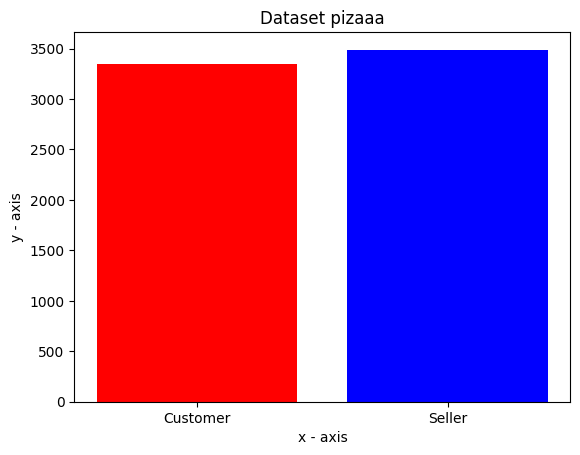

3350
3488


In [5]:
#anyalises dataset
with open('/kaggle/input/ecommerce-dataset/Data/data_1.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
    # print(data)
utteracnes_customer = 0
utteracnes_seller = 0
for d in data:
  dialog = d['dialog']

  for idx in range(len(dialog)):
    if dialog[idx]['role'] == 'customer':
      # print(dialog[idx]['role'])
      utteracnes_customer +=1
    elif dialog[idx]['role'] == 'seller':
      utteracnes_seller +=1

c1 = ['red', 'blue']
height = (utteracnes_customer, utteracnes_seller)
bars = ('Customer', 'Seller')
plt.bar(bars, height, color = c1, width = 0.8)
plt.title("Dataset pizaaa")
plt.xlabel("x - axis")
plt.ylabel("y - axis")
plt.show()
print(utteracnes_customer)
print(utteracnes_seller)

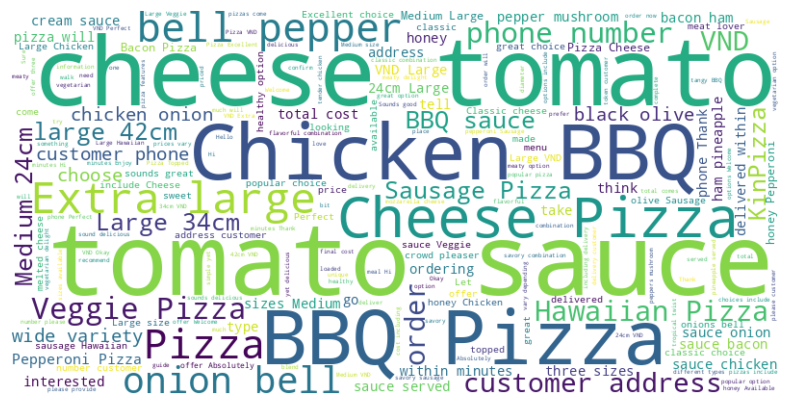

In [6]:
with open('/kaggle/input/ecommerce-dataset/Data/data_1.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
all_text = []
for d in data:
    dialog = d.get('dialog', [])
    for item in dialog:
        text = item.get('text', '')
        if isinstance(text, list):
            text = " ".join(str(t) for t in text)
        all_text.append(text)
combined_text = " ".join(all_text)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [7]:
#confusion matrix
def confusion_maxtrix(dataset):
    pass

In [8]:
class CustomData(Dataset):
  def __init__(self, root, bert_token, bert_model, max_seq_len = 10):
    self.dialog_data = []
    self.states = []
    self.actions = []
    self.next_states = []
    self.max_seq_len = max_seq_len
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with open('/kaggle/input/ecommerce-dataset/Data/data_1.json', 'r', encoding='utf-8') as f:
      datas = json.load(f)

    self.tokenizer = bert_token
    self.bert_model = bert_model.to(self.device)
    self.bert_model.eval()
    self.bert_model.to(self.device)
      
      
    for data in datas:
        dialog = data['dialog']
        customer_utterances = []
        seller_utterances = []
        flag = 0

        for idx in range(len(dialog)):
          if dialog[idx]['role'] == 'customer':
            utterances = "<User>" + "/n" + dialog[idx]['text'] + "<End>" + "/n"
            # print('utterances', utterances)
            if flag == 0:
              customer_utterances.append(utterances)
              flag = 1
            else:
              customer_utterances[-1] += utterances


          if dialog[idx]['role'] == 'seller':
                        utterance = "<|Assistant|>\n" + dialog[idx]['text'] + "<|End|>\n"
                        # print('Seller_utterances', seller_utterances)
                        if flag == 1:
                            seller_utterances.append(utterance)
                            flag = 0
                        else:
                            seller_utterances[-1] += utterance
          history = ["<|Assistant|>/n I'm a KinPizza chatbot, what can I help you with?<|End|>/n"]
        #customer this dataset to states, actions, next_states
          for idx in range(len(seller_utterances)):
            sequence = history[-self.max_seq_len:] if len(history) >= self.max_seq_len else history[:]
            self.dialog_data.append(sequence)
            history.append(customer_utterances[idx])
            # print(history)
            self.states.append(''.join(history))
            self.actions.append(seller_utterances[idx])
            history.append(seller_utterances[idx])
            self.next_states.append(customer_utterances[idx+1] if idx+1 < len(seller_utterances) else "<|End|>")
            # self.dialog_data.append((self.states, self.actions,self.next_states))
            # print('next_states', self.next_states)
    

  def __len__(self):
        return len(self.actions)
      
  def encode_sequence(self, sequence):
      embedding = []
      for text in sequence:
          input = self.tokenizer(text, return_tensors = "pt", max_length = 128, truncation = True, padding = "max_length")
          input = {k: v.to(self.device) for k, v in input.items()}
          with torch.no_grad():
              output = self.bert_model(**input)
          embedding.append(output.last_hidden_state[:, 0, :].squeeze().cpu().numpy())

        
      while len(embedding) < self.max_seq_len:
          embedding.append(np.zeros(768))
      return np.stack(embedding)  
      


  def get_action(self, idx):
      print("Actions:", self.actions[idx])
      return self.actions[idx]


  def get_states(self, idx):
      print("States:", self.states[idx])
      return self.states[idx]
      
  # def get_dialog(self, idx):
  #     print("Dialog:", self.dialog_data[idx])
  #     return self.dialog_data[idx]


  def __getitem__(self, idx):
        # print("States:", self.states[idx])
        # print("Actions:", self.actions[idx])
        # print("Next states:", self.next_states[idx])
        sequence = self.encode_sequence(self.dialog_data[idx])  
        return (self.states[idx], self.actions[idx], self.next_states[idx])

    

In [9]:
#load BERT model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
#Load Phi-2 model
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2")
model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2")
#Load all-mpnet-base v2
reward_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [10]:
dataset = '/kaggle/input/ecommerce-dataset/Data/data_1.json'
data = CustomData(dataset, bert_tokenizer, bert_model)
print(data.__getitem__(4))

("<|Assistant|>/n I'm a KinPizza chatbot, what can I help you with?<|End|>/n<User>/nHi, I'm interested in ordering a pizza from KinPizza. What types of pizzas do you offer?<End>/n", '<|Assistant|>\nWelcome! We have a wide variety of pizzas to choose from. Our most popular choices include:\n Cheese Pizza: A classic choice with cheese and cream sauce, served with honey.\n Chicken BBQ Pizza: A flavorful combination of cheese, tomato sauce, chicken, onion, bell pepper, and BBQ sauce.\n Veggie Pizza: A healthy option with cheese, tomato sauce, onion, bell pepper, mushroom, and black olive.\n Sausage Pizza: A meaty delight with cheese, tomato sauce, and sausage.\n Hawaiian Pizza: A unique twist on pizza with cheese, tomato sauce, bacon, ham, pineapple, and honey.\n Pepperoni Pizza: A crowd-pleaser with cheese, tomato sauce, and pepperoni.<|End|>\n', "<User>/nThat sounds great! I'm thinking about ordering the Cheese Pizza. What are the different sizes and prices?<End>/n")


In [11]:
print(data.__len__())

20639


In [12]:
class ActionSpace:
    def __init__(self, root_path, tokenizer, model):
        self.actions = []
        self.load_actions(root_path)
        self.all_action_space = []
        self.tokenizer = tokenizer
        self.model = model
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    def load_actions(self, root_path):
        with open(root_path, 'r', encoding='utf-8') as f:
            datas = json.load(f)
            for data in datas:
                dialog = data["dialog"]
                for turn in dialog:
                    if turn['role'] == "seller":
                        self.actions.append(turn['text'])

    def get_action(self, idx):
        if 0 <= idx < len(self.actions):
            return self.actions[idx]
        return None

    def get_all_action_space2(self):
        self.all_action_space = list(self.actions)
        return self.all_action_space

In [13]:
#define use LLM to compute consine of action space

action_space = ActionSpace(dataset, tokenizer, model)
# action_space.get_all_action_space2()

In [14]:
action_space_dict = action_space.get_all_action_space2()
# print(action_space_dict)

In [15]:
class Agent(nn.Module):
    def __init__(self, tokenizer, model, model_path=None, 
                 max_length=128, device=None):
        super(Agent, self).__init__()
        
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = self.setup_tokenizer(tokenizer)
        self.model = self.setup_model(model)
        self.max_length = max_length

        self.to(self.device)
        self.logger = logging.getLogger(__name__)

    def setup_tokenizer(self, tokenizer):
        """Thêm các token đặc biệt cho tokenizer."""
        SPECIAL_TOKENS_DICT = {"pad_token": "<pad>", "eos_token": "<|END|>"}
        new_tokens = ["<|Assistant|>", "<|User|>"]
        tokenizer.add_tokens(new_tokens)
        tokenizer.add_special_tokens(SPECIAL_TOKENS_DICT)
        return tokenizer

    def setup_model(self, model):
        """Resize token embeddings để hỗ trợ tokenizer mới."""
        model.resize_token_embeddings(len(self.tokenizer))
        return model

    def model_based_sampling(self, prompts, n_samples=1):
        """Sinh văn bản từ mô hình ngôn ngữ."""
        try:
            inputs = self.tokenizer(
                prompts, 
                return_tensors="pt", 
                padding='longest', 
                truncation=True, 
                max_length=self.max_length
            ).to(self.device)

            with torch.no_grad():
                outputs = self.model.generate(
                    input_ids=inputs["input_ids"],
                    attention_mask=inputs["attention_mask"],
                    max_length=self.max_length,
                    num_return_sequences=n_samples,
                    do_sample=True,
                    top_k=50,
                    top_p=0.95,
                    temperature=1.0,
                    pad_token_id=self.tokenizer.pad_token_id,
                    eos_token_id=self.tokenizer.eos_token_id,
                    no_repeat_ngram_size=2,
                    early_stopping=True
                )

            results = []
            for i in range(0, len(outputs), n_samples):
                batch_outputs = outputs[i:i + n_samples]
                decoded = [
                    self.tokenizer.decode(out, skip_special_tokens=False).strip() 
                    for out in batch_outputs
                ]
                results.extend(decoded)

            return results
        except Exception as e:
            print(f"Error in model-based sampling: {e}")
            return [""] * len(prompts)

    def sampling(self, prompt, n_samples=1, max_length=None):
        """Sinh phản hồi cho 1 prompt."""
        if max_length is not None:
            self.max_length = max_length
        if isinstance(prompt, str):
            prompt = [prompt]
        return self.model_based_sampling(prompt, n_samples)

    def batch_sampling(self, prompts, n_samples=1, max_length=None):
        """Sinh phản hồi cho danh sách prompt."""
        if max_length is not None:
            self.max_length = max_length
        return self.model_based_sampling(prompts, n_samples)

    def forward(self, input_ids, attention_mask=None, **kwargs):
        """Cho phép dùng như mô hình nn.Module bình thường."""
        return self.model(input_ids=input_ids, attention_mask=attention_mask, **kwargs)

    def __repr__(self):
        return f"Agent(device={self.device}, max_length={self.max_length})"


In [16]:
agent = Agent(tokenizer, model)

In [17]:

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state):
        self.buffer.append((state, action, reward, next_state))

    def sample(self, batch_size):
        state, action, reward, next_state = zip(*random.sample(self.buffer, batch_size))
        reward = torch.FloatTensor(reward)
        return list(state), list(action), reward, list(next_state)

    def __len__(self):
        return len(self.buffer)

    def __getitem__(self, idx):
        if isinstance(idx, slice):
            return list(self.buffer)[idx]
        else:
            return self.buffer[idx]


In [18]:
class QNetwork(nn.Module):
    def __init__(self, latent_state_dim=64, action_embedding_dim=3488, hidden_dim=256):
        super(QNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_state_dim + action_embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # Q-value output là 1 số thực
        )

    def forward(self, x):
        return self.net(x)

In [19]:
class WorldModel(nn.Module):
    def __init__(self, model, latent_dim=64, hidden_dim=256, num_layers=4, num_heads=8):
        super(WorldModel, self).__init__()
        
        # BERT encoder
        self.bert = model
        bert_dim = self.bert.config.hidden_size #768 for base
        
        # VAE latent projection
        self.fc_mu = nn.Linear(bert_dim, latent_dim)
        self.fc_logvar = nn.Linear(bert_dim, latent_dim)
        
        # Transformer dynamics (state + action → next_state_latent)
        encoder_layer = nn.TransformerEncoderLayer(d_model=latent_dim, nhead=num_heads, dim_feedforward=hidden_dim)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Prediction heads
        self.next_state_pred = nn.Linear(latent_dim, latent_dim)  # predict latent of next state
        self.reward_pred = nn.Linear(latent_dim, 1)  # scalar reward

    def encode_state(self, input_ids, attention_mask, token_type_ids = None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids = token_type_ids)
        cls_embed = outputs.last_hidden_state[:, 0, :]  # CLS token
        mu = self.fc_mu(cls_embed)
        logvar = self.fc_logvar(cls_embed)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, state_input, action_input):
        """
        state_input, action_input: dict from tokenizer
        """
        mu_s, logvar_s = self.encode_state(**state_input)
        z_s = self.reparameterize(mu_s, logvar_s)  # [batch, latent]
        
        mu_a, logvar_a = self.encode_state(**action_input)
        z_a = self.reparameterize(mu_a, logvar_a)
        
        # Combine state + action
        seq = torch.stack([z_s, z_a], dim=0)  # [seq_len=2, batch, latent]
        memory = self.transformer_encoder(seq)  # [seq_len, batch, latent]
        
        # Use the last token (action) output to predict next state + reward
        last_output = memory[-1]  # [batch, latent]
        next_state_latent = self.next_state_pred(last_output)
        reward = self.reward_pred(last_output).squeeze(-1)
        
        return next_state_latent, reward, mu_s, logvar_s


In [20]:
class Reward():
    def __init__():
        pass

In [21]:
class RealEnvironment(gym.Env):
    def __init__(self, dataset, action_space, tokenizer, bert_model, reward_model):
        super(RealEnvironment, self).__init__()
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.bert_model = bert_model
        self.reward_model = reward_model
        self.bert_model.eval()
        
        # Action space setup
        self.action_space_dict = action_space
        self.num_actions = len(self.action_space_dict)
        self.index_to_action = {i: action for i, action in enumerate(self.action_space_dict)}
        self.action_to_index = {action: i for i, action in enumerate(self.action_space_dict)}
        
        # Environment spaces
        self.observation_space = spaces.Text(max_length=1024)
        self.action_space = spaces.Discrete(self.num_actions)
        
        # Dialog state
        self.current_dialog_idx = 0
        self.dialog_history = []
        self.current_step = 0
        
        # Device setup
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.bert_model.to(self.device)
        self.reward_model.to(self.device)
        self.embedding_cache = {}
    def compute_reward(self, action, next_state):
        """Compute composite reward with length, semantic, and progress components"""
        length_reward = 0.2 * torch.sigmoid(torch.tensor(len(action)/256 - 0.5)).item()
        
        # Cache embeddings for efficiency
        if action not in self.embedding_cache:
            self.embedding_cache[action] = self.reward_model.encode(action, convert_to_tensor=True)
        if next_state not in self.embedding_cache:
            self.embedding_cache[next_state] = self.reward_model.encode(next_state, convert_to_tensor=True)
            
        a_emb = self.embedding_cache[action]
        n_emb = self.embedding_cache[next_state]
        similarity = util.cos_sim(a_emb, n_emb).item()
        
        semantic_reward = 0.7 * (similarity + 1) / 2  # Normalized to [0, 0.7]
        progress_reward = 0.1 * similarity
        
        return max(0.0, min(1.0, length_reward + semantic_reward + progress_reward))

    def _encode_text(self, text):
        """Encode text to embedding"""
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            max_length=128,
            truncation=True,
            padding='longest'
        ).to(self.device)
        with torch.no_grad():
            outputs = self.bert_model(**inputs)
        return outputs.last_hidden_state[:, 0, :]

    def reset(self):
        """Reset environment with new dialog from dataset"""
        self.current_dialog_idx = random.randint(0, len(self.dataset) - 1)
        self.dialog_history = ["<System> Conversation started"]
        self.current_step = 0
        
        # Get first utterance from dataset
        first_utterance = self.dataset.__getitem__(self.current_dialog_idx)
        self.dialog_history.append(first_utterance)
        
        return first_utterance

    def step(self, action_index):
        """Execute one step in real environment"""
        # Convert action to text
        action_text = self.index_to_action.get(action_index, self.index_to_action[0])
        self.dialog_history.append(f"<Assistant> {action_text}")
        
        # Initialize default values
        reward = 0.0
        done = False
        info = {}
        
        # Get next response from dataset
        if self.current_step < len(self.dataset.__getitem__(self.current_dialog_idx)):
            next_utterance = self.dataset.__getitem__(self.current_dialog_idx)
            reward = self.compute_reward(action_text, next_utterance)
            print("This is action text", action_text)
            print("This is reward when training in real environment",reward)
            self.dialog_history.append(next_utterance)
            self.current_step += 1
            
            # Check for termination
            if next_utterance == "<|End|>":
                done = True
            elif self.current_step >= len(self.dataset.__getitem__(self.current_dialog_idx)):
                done = True
        else:
            next_utterance = "<|End|>"
            done = True
            
        return " ".join(self.dialog_history[-3:]), reward, done, info

    def render(self, mode='human'):
        """Render current dialog state"""
        print("\n=== Real Dialog ===")
        for i, turn in enumerate(self.dialog_history):
            print(f"Turn {i+1}: {turn}")
        print("==================")

In [22]:
class VirtualEnvironment(gym.Env):
    def __init__(self, world_model, action_space, tokenizer, bert_model, reward_model , max_seq_len=10, max_dialog_length=20):
        super(VirtualEnvironment, self).__init__()
        self.world_model = world_model
        self.tokenizer = tokenizer
        self.bert_model = bert_model
        self.reward_model = reward_model
        self.bert_model.eval()
        
        # Action space setup
        self.action_space_dict = action_space
        self.num_actions = len(self.action_space_dict)
        self.index_to_action = {i: action for i, action in enumerate(self.action_space_dict)}
        self.action_to_index = {action: i for i, action in enumerate(self.action_space_dict)}
        
        # Environment spaces
        self.observation_space = spaces.Text(max_length=1024)
        self.action_space = spaces.Discrete(self.num_actions)
        
        # Dialog management
        self.max_seq_len = max_seq_len
        self.max_dialog_length = max_dialog_length
        self.dialog_history = []
        self.possible_responses = self.action_space_dict.copy()
        
        # Device setup
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.world_model.to(self.device)
        self.bert_model.to(self.device)
        self.reward_model.to(self.device)
        self.embedding_cache = {}
        
    def compute_reward(self, action, next_state):
        """Compute composite reward with length, semantic, and progress components"""
        length_reward = 0.2 * torch.sigmoid(torch.tensor(len(action)/256 - 0.5)).item()
        
        # Cache embeddings for efficiency
        if action not in self.embedding_cache:
            self.embedding_cache[action] = self.reward_model.encode(action, convert_to_tensor=True)
        if next_state not in self.embedding_cache:
            self.embedding_cache[next_state] = self.reward_model.encode(next_state, convert_to_tensor=True)
            
        a_emb = self.embedding_cache[action]
        n_emb = self.embedding_cache[next_state]
        similarity = util.cos_sim(a_emb, n_emb).item()
        
        semantic_reward = 0.7 * (similarity + 1) / 2  # Normalized to [0, 0.7]
        progress_reward = 0.1 * similarity
        
        return max(0.0, min(1.0, length_reward + semantic_reward + progress_reward))

    
    def _encode_text(self, text):
        """Encode single text to embedding using BERT"""
        inputs = self.tokenizer(
            text, 
            return_tensors="pt", 
            max_length=128, 
            truncation=True, 
            padding='longest'
        ).to(self.device)
        with torch.no_grad():
            outputs = self.bert_model(**inputs)
        return outputs.last_hidden_state[:, 0, :]  # CLS token embedding

    def _encode_sequence(self, sequence):
        """Encode dialog sequence to fixed-length representation"""
        # Get most recent utterances
        recent_utterances = sequence[-self.max_seq_len:]
        
        # Encode each utterance
        embeddings = []
        for text in recent_utterances:
            emb = self._encode_text(text)
            embeddings.append(emb)
        
        # Pad if sequence is shorter than max_seq_len
        while len(embeddings) < self.max_seq_len:
            embeddings.insert(0, torch.zeros(1, 768).to(self.device))
        
        # Stack and return (1, seq_len, 768)
        return torch.cat(embeddings, dim=0).unsqueeze(0)

    def reset(self):
        """Reset the environment with a new dialog"""
        self.dialog_history = []
        
        # Initial prompts
        initial_prompts = [
            "<User> Hi, I'd like to order a pizza from KinPizza. What do you recommend?",
            "<User> What vegetarian options do you have?",
            "<User> How long does delivery take to downtown?"
        ]
        
        # Select random initial state
        initial_obs = random.choice(initial_prompts)
        self.dialog_history.append(initial_obs)
        
        return initial_obs

    def step(self, action_index):
        """
        Execute one step in the environment
        
        Args:
            action_index: Index of the action to take
            
        Returns:
            obs: Current dialog history as text
            reward: Computed reward
            done: Whether the episode is complete
            info: Additional information
        """
        # Convert action index to text
        action_text = self.index_to_action.get(action_index, self.index_to_action[0])
        self.dialog_history.append(f"<Assistant> {action_text}")
        
        # Check termination conditions
        if len(self.dialog_history) >= self.max_dialog_length:
            return " ".join(self.dialog_history), 0.0, True, {}
            
        if action_text == "<|End|>":
            return " ".join(self.dialog_history), 0.0, True, {}
        
        # Encode current state (dialog history)
        state_embedding = self._encode_sequence(self.dialog_history)
        
        # Convert action to tensor
        action_tensor = torch.tensor([action_index], device=self.device)
        
        # World model prediction
        with torch.no_grad():
            next_state_emb, reward_pred, response_logits = self.world_model(
                state_embedding, 
                action_tensor
            )
            
            # Sample response
            response_probs = torch.softmax(response_logits, dim=-1)
            response_idx = Categorical(probs=response_probs).sample().item()
            
        # Get response text
        response_text = self.possible_responses[
            min(response_idx, len(self.possible_responses)-1)
        ]
        
        # Update dialog history
        self.dialog_history.append(f"<User> {response_text}")
        
        # Compute reward (can be enhanced)
        reward = self.compute_reward(action_text, respp)
        
        # Check if response indicates end
        done = response_text == "<|End|>"
        
        return " ".join(self.dialog_history), reward, done, {}

    def render(self, mode='human'):
        """Render current dialog state"""
        print("\n=== Current Dialog ===")
        for i, turn in enumerate(self.dialog_history):
            print(f"Turn {i+1}: {turn}")
        print("=====================")

In [23]:
class WorldModelTrainer:
    def __init__(self, world_model, tokenizer, latent_dim=64, lr=1e-4):
        self.world_model = world_model
        self.tokenizer = tokenizer
        self.latent_dim = latent_dim
        
        self.criterion_state = MSELoss()
        self.criterion_reward = MSELoss()
        self.optimizer = optim.Adam(world_model.parameters(), lr=lr)
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.world_model.to(self.device)

    def train(self, replay_buffer, num_epochs=5, batch_size = 16):
        if len(replay_buffer) < batch_size:
            print(f"Not enough samples ({len(replay_buffer)}) to train.")
            return
        
        for epoch in range(num_epochs):
            total_loss = 0.0
            num_batches = len(replay_buffer) // batch_size
            
            for i in range(0, len(replay_buffer), batch_size):
                batch = list(itertools.islice(replay_buffer, i, i+batch_size))
                states, actions, rewards, next_states = zip(*batch)
                
                # Tokenize
                state_inputs = self.tokenizer(list(states), return_tensors="pt", padding='longest', truncation=True, max_length=128).to(self.device)
                action_inputs = self.tokenizer(list(actions), return_tensors="pt", padding='longest', truncation=True, max_length=64).to(self.device)
                next_state_inputs = self.tokenizer(list(next_states), return_tensors="pt", padding='longest', truncation=True, max_length=128).to(self.device)
                
                # Ground truth next state latent
                with torch.no_grad():
                    mu_ns, logvar_ns = self.world_model.encode_state(**next_state_inputs)
                    z_next_state_true = self.world_model.reparameterize(mu_ns, logvar_ns)
                
                rewards_tensor = torch.tensor(rewards, dtype=torch.float32).to(self.device)
                
                # Forward pass
                z_next_state_pred, reward_pred, mu_s, logvar_s = self.world_model(state_inputs, action_inputs)
                
                # Losses
                loss_state = self.criterion_state(z_next_state_pred, z_next_state_true)
                loss_reward = self.criterion_reward(reward_pred, rewards_tensor)
                loss_kl = -0.5 * torch.mean(1 + logvar_s - mu_s.pow(2) - logvar_s.exp())  # KL for VAE
                
                loss = loss_state + loss_reward + 0.01 * loss_kl
                
                # Backprop
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                total_loss += loss.item()
            
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/num_batches:.4f}")


In [24]:
class Actor(nn.Module):
    def __init__(self, latent_state_dim=64, num_actions=3488, hidden_dim=256):
        super(Actor, self).__init__()
        self.num_actions = num_actions
        self.net = nn.Sequential(
            nn.Linear(latent_state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_actions)  # Logits for 3488 actions
        )

    def forward(self, state):
        logits = self.net(state)
        return logits

    def sample(self, state):
        logits = self.forward(state)
        dist = Categorical(logits=logits)
        action = dist.sample()  # Action indices: [batch_size]
        log_prob = dist.log_prob(action)  # [batch_size]
        return action, log_prob

    def get_action(self, state, deterministic=False):
        state = state.clone().detach() if isinstance(state, torch.Tensor) else torch.tensor(state, dtype=torch.float32)
        state = state.unsqueeze(0) if state.dim() == 1 else state
        logits = self.forward(state)
        if deterministic:
            action = torch.argmax(logits, dim=-1)
            return action, torch.tensor(0.0, dtype=torch.float32)
        dist = Categorical(logits=logits)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.squeeze(0), log_prob.squeeze(0)

In [25]:
class Critic(nn.Module):
    def __init__(self, latent_state_dim=64, action_embedding_dim = 3488, hidden_dim=256):
        super(Critic, self).__init__()
        # Q1 architecture
        #here latent_state_dim + action = 96 (96, 256)
        self.l1 = nn.Linear(latent_state_dim + action_embedding_dim, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.l3 = nn.Linear(hidden_dim, 1)
        
        # Q2 architecture
        # self.l4 = nn.Linear(latent_state_dim + action_embedding_dim, hidden_dim)
        # self.l5 = nn.Linear(hidden_dim, hidden_dim)
        # self.l6 = nn.Linear(hidden_dim, 1)

    def forward(self, state, action):
        sa = torch.cat([state, action], dim=1)
        
        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)
        
        # q2 = F.relu(self.l4(sa))
        # q2 = F.relu(self.l5(q2))
        # q2 = self.l6(q2)
        
        # return q1, q2
        return q1

In [26]:
class MBPO:
    def __init__(self, real_env, virtual_env, action_space_dict, tokenizer, model, reward_model,
                 observation_dim=768, hidden_dim=256, num_layers=4, num_heads=8, 
                 latent_state_dim=64, action_embedding_dim=3488, discount=0.99, lr=1e-4,
                 buffer_capacity=100000, epsilon=0.5, epsilon_decay=0.99, epsilon_min=0.1,
                 tau=0.005, target_update_freq=1000):
        
        # Environment setup
        self.real_env = real_env
        self.virtual_env = virtual_env
        self.tokenizer = tokenizer
        self.model = model
        
        # Hyperparameters
        self.discount = discount
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.tau = tau
        self.target_update_freq = target_update_freq
        self.latent_state_dim = latent_state_dim
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Action space setup
        self.action_space_dict = action_space_dict
        self.num_actions = len(action_space_dict)
        self.action_to_index = {action: i for i, action in enumerate(action_space_dict)}
        self.index_to_action = {i: action for i, action in enumerate(action_space_dict)}
        
        # Initialize World Model
        self.world_model = WorldModel(
            model=self.model,
            latent_dim=latent_state_dim,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            num_heads=num_heads
        ).to(self.device)
        
        # Initialize World Model Trainer
        #training world model to predict next_state
        self.world_model_trainer = WorldModelTrainer(
            world_model=self.world_model,
            tokenizer=self.tokenizer,
            latent_dim=latent_state_dim,
            lr=lr
        )

        # SAC Components
        self.actor = Actor(latent_state_dim, self.num_actions).to(self.device)
        self.critic_1 = Critic(latent_state_dim, action_embedding_dim).to(self.device)
        self.critic_2 = Critic(latent_state_dim, action_embedding_dim).to(self.device)
        self.target_critic_1 = deepcopy(self.critic_1).to(self.device)
        self.target_critic_2 = deepcopy(self.critic_2).to(self.device)
        
        # Optimizers
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        self.critic_1_optimizer = optim.Adam(self.critic_1.parameters(), lr=lr)
        self.critic_2_optimizer = optim.Adam(self.critic_2.parameters(), lr=lr)
        
        # SAC Entropy tuning
        self.log_alpha = torch.tensor(np.log(0.1), requires_grad=True, device=self.device)
        self.alpha_optimizer = optim.Adam([self.log_alpha], lr=lr)
        self.target_entropy = -torch.prod(torch.Tensor(len(action_space_dict)).to(self.device)).item()
        
        # Replay buffer
        self.replay_buffer = ReplayBuffer(capacity=buffer_capacity)
        self.model_buffer = ReplayBuffer(capacity = buffer_capacity)
            
        # Reward model
        self.reward_model = reward_model
        self.reward_model.to(self.device)
        self.embedding_cache = {}

    def compute_reward(self, action, next_state):
        """Compute composite reward with length, semantic, and progress components"""
        length_reward = 0.2 * torch.sigmoid(torch.tensor(len(action)/256 - 0.5)).item()
        
            
        a_emb = self.embedding_cache[action]
        n_emb = self.embedding_cache[next_state]
        similarity = util.cos_sim(a_emb, n_emb).item()
        
        semantic_reward = 0.7 * (similarity + 1) / 2  # Normalized to [0, 0.7]
        progress_reward = 0.1 * similarity
        print("This is reward of action", action, ":", max(0.0, min(1.0, length_reward + semantic_reward + progress_reward)))
        return max(0.0, min(1.0, length_reward + semantic_reward + progress_reward))

    def train_world_model(self, batch_size = 64):
        #Train the world model using real environment samples
        if len(self.replay_buffer) < batch_size:
            return
        #Use world model trainer to handle the training
        self.world_model_trainer.train(
            replay_buffer = self.replay_buffer,
            num_epochs=5, batch_size = batch_size
        )

    def generate_model_rollouts(self, n_rollouts = 100, rollout_length = 5):
        #Generate synthetic rollouts using the trained world model
        if len(self.replay_buffer) < 128:
            return 
        for _ in range(n_rollouts):
            #Samples initial state from buffer
            states, _, _, _ = self.replay_buffer.sample(1)
            state = states[0]

            for _ in range(rollout_length):
                #Tokenize current state
                state_input = self.tokenizer(str(state), return_tensors="pt", padding = 'longest', truncation = True, max_length = 128).to(self.device)
                #select action using current policy
                with torch.no_grad():
                    #what is encode_state
                    mu_s, _ = self.world_model.encode_state(**state_input)
                    #tuple has not argmax
                    action_probs, _ = self.actor.get_action(mu_s, deterministic = True)
                    action_idx = action_probs.item()

                action = self.index_to_action[action_idx]
                action_input = self.tokenizer(action, return_tensors = "pt", padding = 'longest', truncation = True, max_length = 128).to(self.device)

                #predict next state and reward
                with torch.no_grad():
                    next_state_latent, reward, _, _ = self.world_model(state_input, action_input)
                    # next_state_latent, reward, _,_ = self.virtal_env.step(state_input, action_input)
                    #decode next state
                    next_state = f"Generated state from latent: { next_state_latent.cpu().numpy()}"
                    # next_state = self.tokenizer.decode(next_state_latent)
                #store in replay buffer
                self.model_buffer.push(state, action, reward.item() , next_state)
                state = next_state

    def update_policy(self, batch_size=64):
        if len(self.replay_buffer) < batch_size:
            return
        
        # Sample batch
        states, actions, rewards, next_states = self.replay_buffer.sample(batch_size//2)
        states_vir, actions_vir,rewards_vir, next_states_vir = self.model_buffer.sample(batch_size//2)
    
        states.extend(states_vir)
        actions.extend(actions_vir)
        rewards = torch.concat([rewards, rewards_vir], dim = 0)
        next_states.extend(next_states_vir)
        
        rewards = rewards.squeeze(-1) if rewards.dim() > 1 else rewards  # Ensure [batch_size]
        
        # Tokenize and encode states
        state_inputs = self.tokenizer(list(states), return_tensors="pt", padding='longest', truncation=True, max_length=128).to(self.device)
        next_state_inputs = self.tokenizer(list(next_states), return_tensors="pt", padding='longest', truncation=True, max_length=128).to(self.device)
        
        # Convert actions to indices
        action_indices = torch.LongTensor([self.action_to_index[a] for a in actions]).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)  # [batch_size, 1]
        
        # Get latent representation
        with torch.no_grad():
            mu_s, _ = self.world_model.encode_state(**state_inputs)  # [batch_size, state_dim]
            mu_ns, _ = self.world_model.encode_state(**next_state_inputs)  # [batch_size, state_dim]
        
        # Convert action indices to one-hot embeddings
        action_embeddings = F.one_hot(action_indices, num_classes=self.num_actions).float()  # [batch_size, 3488]
        
        # SAC Update - Critic
        with torch.no_grad():
            next_action_indices, next_log_probs = self.actor.sample(mu_ns)  # [batch_size], [batch_size]
            next_action_embeddings = F.one_hot(next_action_indices, num_classes=self.num_actions).float()  # [batch_size, 3488]
            next_q1 = self.target_critic_1(mu_ns, next_action_embeddings)  # [batch_size, 1]
            next_q2 = self.target_critic_2(mu_ns, next_action_embeddings)  # [batch_size, 1]
            next_q = torch.min(next_q1, next_q2).squeeze(-1) - self.log_alpha.exp() * next_log_probs  # [batch_size]
            target_q = rewards + self.discount * next_q  # [batch_size]
        
        current_q1 = self.critic_1(mu_s, action_embeddings)  # [batch_size, 1]
        current_q2 = self.critic_2(mu_s, action_embeddings)  # [batch_size, 1]
        critic_loss = F.mse_loss(current_q1, target_q.unsqueeze(-1)) + F.mse_loss(current_q2, target_q.unsqueeze(-1))
        
        self.critic_1_optimizer.zero_grad()
        self.critic_2_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_1_optimizer.step()
        self.critic_2_optimizer.step()
        
        # SAC Update - Actor
        new_action_indices, log_probs = self.actor.sample(mu_s)  # [batch_size], [batch_size]
        new_action_embeddings = F.one_hot(new_action_indices, num_classes=self.num_actions).float()  # [batch_size, 3488]
        q1 = self.critic_1(mu_s, new_action_embeddings)  # [batch_size, 1]
        q2 = self.critic_2(mu_s, new_action_embeddings)  # [batch_size, 1]
        actor_loss = (self.log_alpha.exp() * log_probs - torch.min(q1, q2).squeeze(-1)).mean()
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # SAC Update - Alpha
        alpha_loss = -(self.log_alpha * (log_probs + self.target_entropy).detach()).mean()
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()        
        
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters"""
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
            
    def train(self, dataset, epochs = 2, step_per_epoch = 1000, model_train_interval = 100, policy_update_interval = 50, rollout_interval = 200, batch_size = 64):
        #main training loop
        #initial data collection

        print("Collecting initial real samples....")
        for _ in range(1000):
            state = random.choice(dataset)[0]
            action_idx = self.select_action(state)
            action = self.index_to_action[action_idx]
            next_state, reward, done, _ = self.real_env.step(action_idx)
            self.replay_buffer.push(state, action, reward, next_state)

        for epoch in range(epochs):
            epoch_rewards = []

            for step in range(step_per_epoch):
                #Environment interaction
                if step % 10 == 0:
                    state = random.choice(dataset)[0]

                action_idx = self.select_action(state)
                action = self.index_to_action[action_idx]
                #chua tan dung duoc moi truong ao 
                next_state, reward, done, _ = self.real_env.step(action_idx)
                self.replay_buffer.push(state, action, reward, next_state)

                #training world model
                
                state = next_state
                epoch_rewards.append(float(reward))

                #WorldModel training
                if step % model_train_interval == 0:
                    self.train_world_model(batch_size)

                #Model rollout
                if step % rollout_interval == 0:
                    self.generate_model_rollouts(n_rollouts= 5)

                #Policy updates
                if step % policy_update_interval == 0:
                    self.update_policy(batch_size)
                    
                # Target network updates
                if step % self.target_update_freq == 0:
                    self.soft_update(self.critic_1, self.target_critic_1, self.tau)
                    self.soft_update(self.critic_2, self.target_critic_2, self.tau)
            
            # Epoch statistics
            avg_reward = np.mean(epoch_rewards)
            print(f"Epoch {epoch+1}/{epochs} | Avg Reward: {avg_reward:.2f} | "
                  f"Buffer Size: {len(self.replay_buffer)} | "
                  f"Alpha: {self.log_alpha.exp().item():.3f}")
            
            # Epsilon decay
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


    def select_action(self, state, deterministic = False):
        #Select action using current policy with epsilon greedy exploraion
        if random.random() < self.epsilon and not deterministic:
            return random.randint(0, self.num_actions - 1)

        tokenized = self.tokenizer(str(state), return_tensors = "pt", padding = 'longest', truncation = True, max_length = 128).to(self.device)
      # Filter only the needed inputs
        state_input = {
            'input_ids': tokenized['input_ids'],
            'attention_mask': tokenized['attention_mask']
        }
        
        # Add token_type_ids only if they exist
        if 'token_type_ids' in tokenized:
            state_input['token_type_ids'] = tokenized['token_type_ids']
            
        with torch.no_grad():
            mu_s, _ = self.world_model.encode_state(**state_input)
            # action = self.actor.get_action(mu_s, deterministic = True)
            # action_idx =  int(action.detach().squeeze().cpu().numpy().argmax())
            action_idx, _ = self.actor.get_action(mu_s, deterministic = True)
            return action_idx.item()
        

    def save_models(self, save_dir):
        """Save all model components"""
        os.makedirs(save_dir, exist_ok=True)
        
        torch.save({
            'world_model': self.world_model.state_dict(),
            'actor': self.actor.state_dict(),
            'critic_1': self.critic_1.state_dict(),
            'critic_2': self.critic_2.state_dict(),
            'target_critic_2': self.target_critic_2.state_dict(),
            'target_critic_1': self.target_critic_1.state_dict(),
            'log_alpha': self.log_alpha,
            'actor_optimizer': self.actor_optimizer.state_dict(),
            'critic_optimizer': self.critic_1_optimizer.state_dict(),
            'alpha_optimizer': self.alpha_optimizer.state_dict(),
        }, os.path.join(save_dir, 'working/mbpo_models.pth'))
        
        print(f"Models saved to {save_dir}")






In [27]:
class ModelTester:
    def __init__(self, mbpo, replay_buffer, action_space_dict, agent, sentence_transformer, real_env, virtual_env):
        self.mbpo = mbpo
        self.replay_buffer = replay_buffer
        self.action_space_dict = action_space_dict
        self.agent = agent
        self.sentence_transformer = sentence_transformer
        self.real_env = real_env
        self.virtual_env = virtual_env
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def test_model(self, test_data=None, num_episodes=100, use_real_env=True, ground_truth_responses=None, output_file="test_results.json"):
        start_time = time.time()
        results = {
            "average_reward": 0.0,
            "semantic_similarity": 0.0,
            "response_diversity": 0.0,
            "valid_action_rate": 0.0,
            "computation_time": 0.0,
            "responses": [],
            "errors": []
        }
        rewards = []
        similarities = []
        action_indices = []
        valid_actions = 0
        env = self.real_env if use_real_env else self.virtual_env
        print("We will use:" , env)
        for episode in range(num_episodes):
            # Khởi tạo trạng thái
            state = test_data[episode] if test_data and episode < len(test_data) else env.reset()
            done = False
            episode_rewards = []
            episode_actions = []
            episode_responses = []

            while not done:
                # Chọn hành động
                action_idx = self.mbpo.select_action(state)
                action_text = self.mbpo.index_to_action.get(action_idx, "Sorry, I couldn't process your request. Please try again.")
                if action_text == "Sorry, I couldn't process your request. Please try again.":
                    results["errors"].append({
                        "episode": episode,
                        "action_idx": action_idx,
                        "state": state
                    })
                else:
                    valid_actions += 1

                # Tinh chỉnh phản hồi bằng Phi-2
                response = self.agent.model_based_sampling(action_text)
                episode_responses.append({
                    "state": state,
                    "action_idx": action_idx,
                    "response": response,
                    "action_text": action_text
                })

                # Bước tiếp theo trong môi trường
                next_state, reward, done, _ = env.step(action_idx)
                episode_rewards.append(reward)
                episode_actions.append(action_idx)

                # Tính độ tương đồng ngữ nghĩa
                target_text = ground_truth_responses[episode] if ground_truth_responses and episode < len(ground_truth_responses) else next_state
                a_emb = self.sentence_transformer.encode(response, convert_to_tensor=True, device=self.device)
                b_emb = self.sentence_transformer.encode(target_text, convert_to_tensor=True, device=self.device)

                # a_emb = a_emb.unsqueeze(0)
                # b_emb = b_emb.unsqueeze(0)

                similarity = util.cos_sim(a_emb, b_emb)[0][0].item()


                similarities.append(similarity)

                state = next_state

            rewards.append(np.mean(episode_rewards))
            print("This is array of reward", rewards)
            action_indices.extend(episode_actions)
            results["responses"].extend(episode_responses)

        # Tính các chỉ số
        results["average_reward"] = np.mean(rewards) if rewards else 0.0
        results["semantic_similarity"] = np.mean(similarities) if similarities else 0.0
        results["response_diversity"] = len(set(action_indices)) / self.mbpo.num_actions if action_indices else 0.0
        results["valid_action_rate"] = valid_actions / (num_episodes * len(episode_actions)) if episode_actions else 0.0
        results["computation_time"] = time.time() - start_time

        # Lưu kết quả
        with open(output_file, "w", encoding="utf-8") as f:
            json.dump(results, f, ensure_ascii=False, indent=4)

        return results

    def print_results(self, results):
        """In ra kết quả kiểm tra."""
        print(f"Average Reward: {results['average_reward']:.4f}")
        print(f"Semantic Similarity: {results['semantic_similarity']:.4f}")
        print(f"Response Diversity: {results['response_diversity']:.4f}")
        print(f"Valid Action Rate: {results['valid_action_rate']:.4f}")
        print(f"Computation Time: {results['computation_time']:.2f} seconds")
        print(f"Number of Errors: {len(results['errors'])}")
        print("\nSample Responses:")
        for i, response in enumerate(results["responses"][:5]):
            print(f"Episode {i}:")
            print(f"  State: {response['state']}")
            print(f"  Action Index: {response['action_idx']}")
            print(f"  Response: {response['response']}")
            print(f"  Action Text: {response['action_text']}")
        if results["errors"]:
            print("\nErrors:")
            for error in results["errors"][:5]:
                print(f"Episode {error['episode']}: Invalid action_idx {error['action_idx']} for state {error['state']}")

In [28]:
replay_buffer = ReplayBuffer(100000)

In [29]:
world_model = WorldModel(model=bert_model,latent_dim=64,hidden_dim=384,num_layers=4,num_heads=8)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [30]:
# 1. Initialize Environments
real_env = RealEnvironment(dataset=dataset,action_space=action_space_dict,tokenizer=bert_tokenizer,
                           bert_model=bert_model, reward_model = reward_model)

virtual_env = VirtualEnvironment(world_model=world_model, action_space=action_space_dict, 
                                 tokenizer=bert_tokenizer, bert_model=bert_model,reward_model = reward_model,max_seq_len=10)

# 2. Initialize Models with proper dimensions
actor = Actor(latent_state_dim=64, num_actions=3500, hidden_dim=384)
critic = Critic(latent_state_dim=64,action_embedding_dim=3488, hidden_dim=384)


# 3. Initialize MBPO
mbpo = MBPO(real_env=real_env,virtual_env=virtual_env, action_space_dict=action_space_dict,
            tokenizer=bert_tokenizer,model=bert_model, reward_model = reward_model, 
            observation_dim=768, hidden_dim=384,num_layers=4,num_heads=8,latent_state_dim=64, 
            action_embedding_dim=3488, lr=1e-4, buffer_capacity=100000)

In [ ]:
 mbpo.train(dataset, epochs = 10, step_per_epoch = 500,
            model_train_interval = 100, policy_update_interval = 50,
            rollout_interval = 30, batch_size = 16)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

This is action text Thank you for your order! The total cost is 269000. Your pizza will be delivered within 30 minutes.
This is reward when training in real environment 0.475430316105485
Epoch 1/5, Loss: 1.8770
Epoch 2/5, Loss: 1.4423
Epoch 3/5, Loss: 0.9200
Epoch 4/5, Loss: 0.6179
Epoch 5/5, Loss: 0.4345


/tmp/ipykernel_31/2980126274.py:174: UserWarning: Using a target size (torch.Size([16, 16, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(current_q1, target_q.unsqueeze(-1)) + F.mse_loss(current_q2, target_q.unsqueeze(-1))


Epoch 1/5, Loss: 0.3165
Epoch 2/5, Loss: 0.7463
Epoch 3/5, Loss: 1.5753
Epoch 4/5, Loss: 0.8181
Epoch 5/5, Loss: 1.7282
Epoch 1/5, Loss: 1.1079
Epoch 2/5, Loss: 1.4702
Epoch 3/5, Loss: 0.9071
Epoch 4/5, Loss: 0.6518
Epoch 5/5, Loss: 0.7636
Epoch 1/5, Loss: 0.6606
Epoch 2/5, Loss: 0.6890
Epoch 3/5, Loss: 0.7134
Epoch 4/5, Loss: 0.6241
Epoch 5/5, Loss: 0.4954
Epoch 1/5, Loss: 0.5746
Epoch 2/5, Loss: 0.6259
Epoch 3/5, Loss: 0.6413
Epoch 4/5, Loss: 0.6526
Epoch 5/5, Loss: 0.6936
Epoch 1/10 | Avg Reward: 0.00 | Buffer Size: 1500 | Alpha: 0.100
Epoch 1/5, Loss: 0.7103
Epoch 2/5, Loss: 0.8436
Epoch 3/5, Loss: 0.5660
Epoch 4/5, Loss: 0.6365
Epoch 5/5, Loss: 0.6871
Epoch 1/5, Loss: 0.7870
Epoch 2/5, Loss: 0.8353
Epoch 3/5, Loss: 0.8565
Epoch 4/5, Loss: 0.8740
Epoch 5/5, Loss: 0.9392
Epoch 1/5, Loss: 0.9391
Epoch 2/5, Loss: 1.0031
Epoch 3/5, Loss: 0.8866
Epoch 4/5, Loss: 0.8614
Epoch 5/5, Loss: 0.4840
Epoch 1/5, Loss: 0.5409
Epoch 2/5, Loss: 0.5947
Epoch 3/5, Loss: 0.6546
Epoch 4/5, Loss: 0.7067

In [ ]:
test_data = [
    "Customer: I want a large Chicken BBQ Pizza.",
    "Customer: How much is a medium Pepperoni Pizza?",
    "Customer: Can you deliver in 20 minutes?",
    "Customer: Any promotions today?"
]
ground_truth_responses = [
    "Perfect choice! The total cost for a large Chicken BBQ Pizza is 269,000 VND.",
    "The total cost for a medium Pepperoni Pizza is 179,000 VND.",
    "We'll try our best to deliver within 30 minutes.",
    "Today we have a 10% discount on all large pizzas!"
]

In [ ]:
# Khởi tạo tester
tester = ModelTester(mbpo, replay_buffer, mbpo.action_space_dict, agent, mbpo.reward_model, real_env, virtual_env)

# Chạy test
results = tester.test_model(
    test_data=test_data,
    num_episodes=50,
    use_real_env=True,  
    ground_truth_responses=ground_truth_responses,
    output_file="working/test_results.json"
)

# In kết quả


In [ ]:
tester.print_results(results)